In [19]:
import os, sys
import numpy as np
from astropy import units
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks


%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

plt.rcParams['font.size'] = 18
wavelength, flux, err = load_binned_data('/Users/arcticfox/Documents/AUMic/reduced/binned_data_a.npy')
wavelength2, flux2, err2 = load_binned_data('/Users/arcticfox/Documents/AUMic/reduced2/binned_data2.npy')

times = np.load('/Users/arcticfox/Documents/AUMic/reduced/times.npy')
orbits = np.load('/Users/arcticfox/Documents/AUMic/reduced/orbits.npy')
times2 = np.load('/Users/arcticfox/Documents/AUMic/reduced2/times.npy')
orbits2 = np.load('/Users/arcticfox/Documents/AUMic/reduced2/orbits.npy')+5

wavelength = np.full(flux.shape, wavelength)
wavelength2 = np.full(flux2.shape, wavelength2)

flare_mask = np.load('/Users/arcticfox/Documents/AUMic/flare_mask.npy',
                     allow_pickle=True)

parula = np.load('/Users/arcticfox/parula_colors.npy')

distance = (9.79*units.pc).to(units.cm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fwc = FlaresWithCOS(wavelength=np.append(wavelength, wavelength2, axis=0), 
                    flux=np.append(flux, flux2, axis=0),
                    flux_err=np.append(err, err2, axis=0), 
                    time=np.append(times, times2)-times[0], 
                    orbit=np.append(orbits, orbits2))
fwc.load_line_table(path='/Users/arcticfox/Documents/GitHub/cos_flares/')

In [4]:
fwc.measure_FUV130()

for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion)

In [5]:
%load_ext autoreload
%autoreload 2
from plot_utils import make_tworow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
visit2_time = np.append(times,times2)-times2[0]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


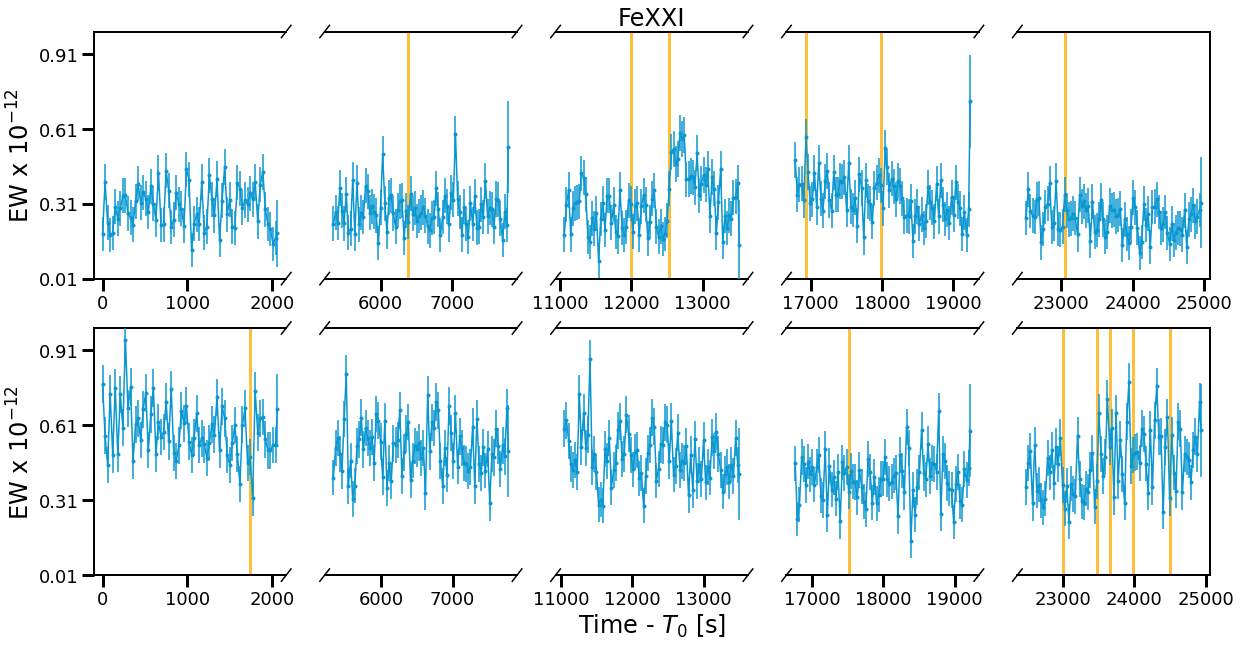

In [43]:
iron = [i for i in fwc.width_table.colnames if 'Fe' in i]

fig, axes = make_tworow()


for i in range(len(axes)):
    q = fwc.orbit == i
    
    if i < 5:
        t = fwc.time.value + 0.0
    else:
        t = visit2_time + 0.0
    
    axes[i].errorbar(t[q],
                     fwc.width_table[iron[1]].data[q], 
                     yerr=fwc.error_table[iron[1]].data[q]/10,
                     marker='.',  color=parula[80], zorder=3)
    
    inds = np.where(np.array(flare_mask[1])==i)[0]
    if len(inds)>0:
        for n in inds:
            argmax = np.argmax(fwc.width_table['SiIII'][flare_mask[2][n]>0])
            axes[i].vlines(t[flare_mask[2][n]>0][argmax],
                           0, 1, color=parula[215], lw=3, zorder=1)#, linestyle='--')
    
    if i == 2:
        axes[i].set_title(iron[1], fontsize=24)
        
    #axes[i].set_ylim(0.9e-12,1e-14)
    axes[i].set_ylim(1e-14,1e-12)
        
    if i == 0 or i == 5:
        axes[i].set_ylabel('EW x 10$^{-12}$', fontsize=24)
        axes[i].set_yticks(np.arange(1e-14,1e-12, 3e-13))
        axes[i].set_yticklabels(np.arange(1e-14,1e-12, 3e-13)/1e-12)
    if i == 7:
        axes[i].set_xlabel('Time - $T_0$ [s]', fontsize=24)
plt.savefig('/Users/arcticfox/Documents/AUMic/figures/FeXXI.png', dpi=250,
            rasterize=True, bbox_inches='tight')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


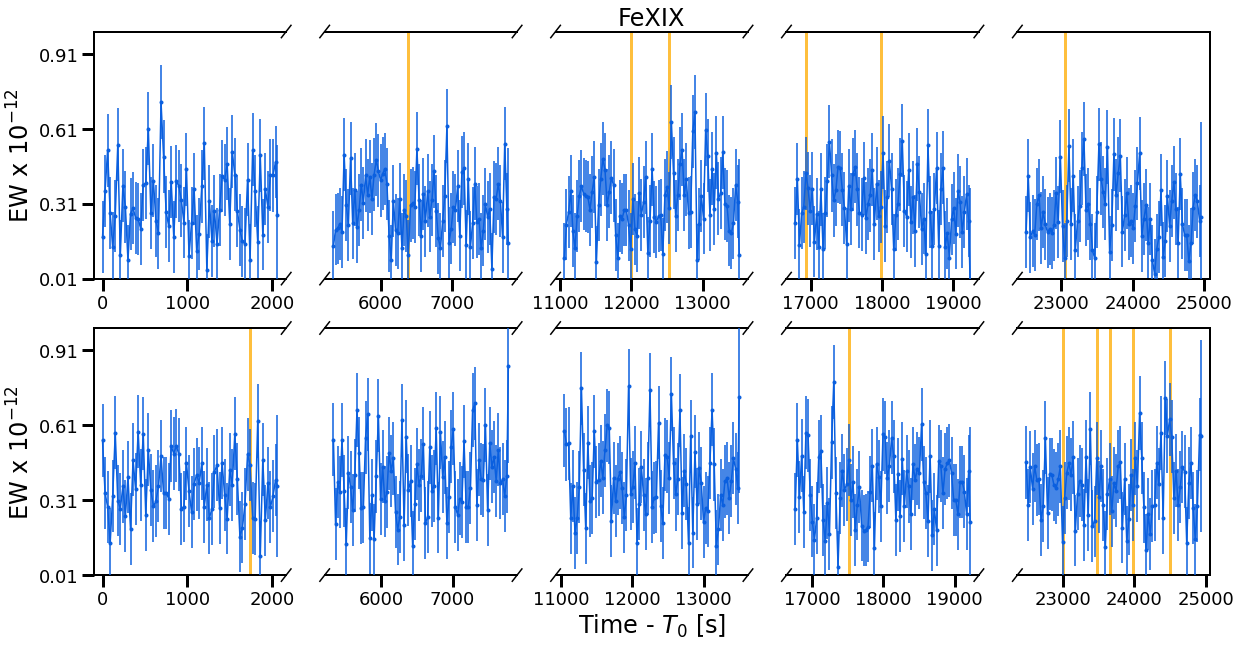

In [45]:
iron = [i for i in fwc.width_table.colnames if 'Fe' in i]

fig, axes = make_tworow()


for i in range(len(axes)):
    q = fwc.orbit == i
    
    if i < 5:
        t = fwc.time.value + 0.0
    else:
        t = visit2_time + 0.0
    
    axes[i].errorbar(t[q],
                     fwc.width_table[iron[0]].data[q], 
                     yerr=fwc.error_table[iron[0]].data[q]/10,
                     marker='.',  color=parula[30], zorder=3)
    
    inds = np.where(np.array(flare_mask[1])==i)[0]
    if len(inds)>0:
        for n in inds:
            argmax = np.argmax(fwc.width_table['SiIII'][flare_mask[2][n]>0])
            axes[i].vlines(t[flare_mask[2][n]>0][argmax],
                           0, 1, color=parula[215], lw=3, zorder=1)#, linestyle='--')
    
    if i == 2:
        axes[i].set_title(iron[0], fontsize=24)
        
    #axes[i].set_ylim(0.9e-12,1e-14)
    axes[i].set_ylim(1e-14,1e-12)
        
    if i == 0 or i == 5:
        axes[i].set_ylabel('EW x 10$^{-12}$', fontsize=24)
        axes[i].set_yticks(np.arange(1e-14,1e-12, 3e-13))
        axes[i].set_yticklabels(np.arange(1e-14,1e-12, 3e-13)/1e-12)
    if i == 7:
        axes[i].set_xlabel('Time - $T_0$ [s]', fontsize=24)
plt.savefig('/Users/arcticfox/Documents/AUMic/figures/FeXIX.png', dpi=250,
            rasterize=True, bbox_inches='tight')

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14,10))
fig.set_facecolor('w')

distance = (9.79 * units.pc).to(units.cm)

q = ((fwc.orbit == 2) & (fwc.time.value<=12370))
f = ((fwc.orbit == 2) & (fwc.time.value>=12350))
energy, duration = fwc.measure_flare_params(q, f, distance, 
                                            flux=fwc.fuv130*10**-13)
label = str(np.round(energy.value/10**30,2)) + ' x 10$^{30}$ erg; '+ str(np.round(duration.value, 2)) + ' s'
ax1.plot(fwc.time[q], fwc.fuv130[q]/10**-13, 'k', lw=3,
         label='Quiescent Flux', marker='o')
ax1.plot(fwc.time[f], fwc.fuv130[f]/10**-13, 'darkorange', lw=3, label=label, marker='o')
ax1.set_ylim(0,35)
#ax1.set_xlim(11100,13550)
ax1.legend()


q = ((fwc.orbit == 3) & (fwc.time.value>=17120) & (fwc.time.value<=17800.943))
f = ((fwc.orbit == 3) & (fwc.time.value<=17140))
energy, duration = fwc.measure_flare_params(q, f, distance,
                                            flux=fwc.fuv130*10**-13)
label = str(np.round(energy.value/10**30,2)) + ' x 10$^{30}$ erg; '+ str(np.round(duration.value, 2)) + ' s'

ax2.plot(fwc.time[q], fwc.fuv130[q]/10**-13, 'k', lw=3,
         label='Quiescent Flux', marker='o')
ax2.plot(fwc.time[f], fwc.fuv130[f]/10**-13, 'darkorange', lw=3, marker='o', label=label)



q = ((fwc.orbit == 3) & (fwc.time.value>=18200))
f = ((fwc.orbit == 3) & (fwc.time.value>=17880.943) & (fwc.time.value<=18200.943))
energy, duration = fwc.measure_flare_params(q, f, distance,
                                            flux=fwc.fuv130*10**-13)
label = str(np.round(energy.value/10**30,2)) + ' x 10$^{30}$ erg; '+ str(np.round(duration.value, 2)) + ' s'

ax2.plot(fwc.time[q], fwc.fuv130[q]/10**-13, 'k', lw=3, marker='o')
ax2.plot(fwc.time[f], fwc.fuv130[f]/10**-13,'deepskyblue', marker='o', lw=3, label=label)


ax2.legend()
ax2.set_ylabel('FUV$_{130}$ [10$^{-13}$erg s$^{-1}$ cm$^{-2}$]', y=1.02, fontsize=24)
ax2.set_xlabel('Time - 59362.14828 [s]', fontsize=24)


plt.subplots_adjust(hspace=0.2)
#plt.savefig('fuv130_flares.png', dpi=250, rasterize=True, bbox_inches='tight')

In [ ]:
diff = np.where(np.diff(fwc.time.value)>100000)[0]
diff = [0, diff[0], len(fwc.time)-1]

fig, axes = plt.subplots(figsize=(25,8), nrows=2, ncols=5)
fig.set_facecolor('w')
axes = axes.reshape(-1)

f_tot = np.full((20,len(fwc.time.value)), False)
x = 0
a = 0
which_o = []
for i in range(len(diff)-1):
    if i == 0:
        jr = [0,5]
        axes[a].set_ylim(1e-13,4e-11)
    else:
        jr = [5,10]
        
        
    for j in range(jr[0], jr[1]):
        mask = np.where((fwc.time.value>=fwc.time.value[diff[i]]) &
                        (fwc.time.value<=fwc.time.value[diff[i+1]]) &
                        (fwc.orbit==j))
        axes[a].errorbar(fwc.time.value[mask], 
                     fwc.width_table['CIII'][mask], 
                     yerr=fwc.error_table['CIII'][mask]/3, 
                     marker='.', color='k',
                     linestyle='')
        axes[a].plot(fwc.time.value[mask], 
                     fwc.width_table['CIII'][mask], 'k')

        
        if j == 1:
            f = ((fwc.time.value>=6300) & (fwc.time.value<=6600))
            f = f.reshape((1,len(f)))
            which_o.append(j)
        elif j == 2:
            f1 = ((fwc.time.value>=11900) & (fwc.time.value<=12100))
            f2 = ((fwc.time.value>=12300) & (fwc.time.value<=13500)) 
            f = np.array([f1, f2])
            which_o.append(j)
            which_o.append(j)
        elif j == 3:
            f1 = ((fwc.time.value>=16800) & (fwc.time.value<=17100) )
            f2 = ((fwc.time.value>=17700) & (fwc.time.value<=18300) ) 
            f = np.array([f1, f2])
            which_o.append(j)
            which_o.append(j)
        elif j == 4:
            f1 = ((fwc.time.value>=22970) & (fwc.time.value<=23150) )
            f = np.array([f1])
            which_o.append(j)
        elif j == 5:
            f = ((fwc.time.value>=10238383) & (fwc.time.value<=10238593))
            f = f.reshape((1,len(f)))
            which_o.append(j)
        elif j == 8:
            f = ((fwc.time.value>=10254152) & (fwc.time.value<=10254452))
            f = f.reshape((1,len(f)))
            which_o.append(j)
        elif j == 9:
            f0 = ((fwc.time.value>=10259581) & (fwc.time.value<=10259781))
            f1 = ((fwc.time.value>=10260101) & (fwc.time.value<=10260351))
            f2 = ((fwc.time.value>10260351) & (fwc.time.value<=10260651))
            f3 = ((fwc.time.value>10260651) & (fwc.time.value<=10260851))
            f4 = ((fwc.time.value>10261151) & (fwc.time.value<=10261501))
            f = np.array([f0, f1, f2, f3, f4])
            which_o.append(j)
            which_o.append(j)
            which_o.append(j)
            which_o.append(j)
            which_o.append(j)
        else:
            f = None
            
            
        if f is not None:
            for k in range(len(f)):
                f_tot[x] = f[k] 
                m1 = f[k] == True
                #axes[a].errorbar(fwc.time.value[m1], 
                #             fwc.width_table['CIII'][m1], 
                #             yerr=fwc.error_table['CIII'][m1]/3, 
                #             marker='.', color=parula[(k*40)+30],
                #             linestyle='')
                axes[a].axvspan(fwc.time.value[m1][0], fwc.time.value[m1][-1],
                                color=parula[(k*40)+30], alpha=0.4)
                x += 1
            
        if j < 5:
            axes[a].set_ylim(1e-13,5e-11)
        else:
            axes[a].set_ylim(1e-12,4e-11)
            if j == 5:
                axes[a].set_ylabel('EW x $ 10^{-11}$', y=1.1, fontsize=26)
            if j == 7:
                axes[a].set_xlabel('Time [s]', fontsize=26)
                
        axes[a].set_yticklabels([1,2,3,4,5,6])
        if j < 5:
            axes[a].set_title('Visit 1; Orbit {}'.format(j+1))
        else:
            axes[a].set_title('Visit 2; Orbit {}'.format(j-4))
        axes[a].set_xlim(fwc.time.value[mask][0], fwc.time.value[mask][-1])
        a += 1
plt.subplots_adjust(hspace=0.4)
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/allflares.png', dpi=250, rasterize=True,
#            bbox_inches='tight')

In [ ]:
f_tot = np.delete(f_tot, np.arange(x,len(f_tot),1,dtype=int),axis=0)

In [ ]:
f_int = np.zeros(f_tot.shape, dtype=int)
for i in range(len(f_tot)):
    f_int[i] = (f_tot[i]+0.0)*2**(i+1)

In [ ]:
np.save('/Users/arcticfox/Documents/AUMic/flare_mask.npy', [fwc.time, which_o, f_int])

In [ ]:
test = fwc.width_table['SiIII'][f_tot[2]==True] + 0.0
ttest = fwc.time[f_tot[2]==True]
plt.plot(ttest, test,'k')
plt.plot(ttest, test, '.')

p1 = np.argmax(test)
plt.plot(ttest[p1], test[p1], 'ro')

arg = np.where((ttest.value>ttest[p1].value+100))[0]
p2 = np.argmax(test[arg])
plt.plot(ttest[arg][p2], test[arg][p2], 'yo')

arg3 = np.where((ttest.value>ttest[arg][p2].value+100))[0]
p3 = np.argmax(test[arg3])
plt.plot(ttest[arg3][p3], test[arg3][p3], 'wo')

t0 = np.array([ttest[p1].value, ttest[arg][p2].value, ttest[arg3][p3].value])
amp = np.array([test[p1], test[arg][p2], test[arg3][p3]])#/1e-13
decay = np.array([70, 30, 40])
rise= np.array([30, 0.001, 0.001])

m = fwc.flare_model(t0=t0, amp=amp, decay=decay, rise=rise, t=ttest.value)
plt.plot(ttest, m+np.nanmin(test))

In [ ]:
%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

In [ ]:
x, model = fwc.fit_flare('SiIII', f_tot[2]==True, nflares=3, amp=amp,
                          t0=t0, decay=decay, rise=rise)

In [ ]:
x